# Setup

In [1]:
import os
import sys
import random
from collections import Counter

import numpy as np
import pyloudnorm as pln
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import display
import librosa.display

In [2]:
# We're going to use utilities from the core framework
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.config import config_from_args
from src.utils.build import build_device, build_datasets

In [3]:
data_path = os.path.abspath(os.path.join("../processed_data/quiet_front-ear"))
config_path = os.path.abspath(os.path.join("../../configs/audio_config.json"))
config = config_from_args([
    f"--data={data_path}",
    f"--config={config_path}",
    f"--dataset=both_mic_classif"
])

In [4]:
device = build_device()
dataset, *_ = build_datasets(config, device)

# Load

In [5]:
raw_data = [dataset.loader.load(i) for i in range(len(dataset))]

# load() returns (input, target, is_train)
raw_inputs, raw_targets, _ = list(zip(*raw_data))

# Each input element is a list of tuples, where each tuple is (channel sample rate, channel data)
# Channels are in ther order [reg mic 1, reg mic 2, throat mic 1, throat mic 2]
raw_reg_1, raw_reg_2, raw_throat_1, raw_throat_2 = list(zip(*raw_inputs))

# Get sample rates
reg_sr = raw_reg_1[0][0]
throat_sr = raw_throat_1[0][0]

# Get just raw data, stripping out sample rate
_, raw_reg_1 = list(zip(*raw_reg_1))
_, raw_reg_2 = list(zip(*raw_reg_2))
_, raw_throat_1 = list(zip(*raw_throat_1))
_, raw_throat_2 = list(zip(*raw_throat_2))

In [6]:
# Each element is a dictionary with keys 'input' and 'target'
# Input is a spectogram, target is an encoded label
processed_data = [d for d in dataset]
processed_inputs = [d["input"].numpy() for d in processed_data]
processed_targets = [d["target"] for d in processed_data]

# Channels are in ther order [reg mic 1, reg mic 2, throat mic 1, throat mic 2]
proc_reg_1 = [spec[0, :, :] for spec in processed_inputs]
proc_reg_2 = [spec[1, :, :] for spec in processed_inputs]
proc_throat_1 = [spec[2, :, :] for spec in processed_inputs]
proc_throat_2 = [spec[3, :, :] for spec in processed_inputs]

In [7]:
# Make by-label splits
labels = list(set(raw_targets))

label_splits = {l: {
    "raw_reg_1": [],
    "raw_reg_2": [],
    "raw_throat_1": [],
    "raw_throat_2": [],
    "proc_reg_1": [],
    "proc_reg_2": [],
    "proc_throat_1": [],
    "proc_throat_2": [],
} for l in labels}

for i, label in enumerate(raw_targets):
    label_splits[label]["raw_reg_1"].append(raw_reg_1[i])
    label_splits[label]["raw_reg_2"].append(raw_reg_2[i])
    label_splits[label]["raw_throat_1"].append(raw_throat_1[i])
    label_splits[label]["raw_throat_2"].append(raw_throat_2[i])
    label_splits[label]["proc_reg_1"].append(proc_reg_1[i])
    label_splits[label]["proc_reg_2"].append(proc_reg_2[i])
    label_splits[label]["proc_throat_1"].append(proc_throat_1[i])
    label_splits[label]["proc_throat_2"].append(proc_throat_2[i])

# Initial Exploration

In [8]:
plt.rcParams['figure.dpi'] = 100  # Make plots appear larger

## Dataset Size

In [9]:
counts = Counter(raw_targets)
counts["all"] = len(dataset)
for key, value in counts.items():
    print(f"{key}: {value} samples")

count_labels = ["Up", "Down", "Select", "Back", "Repeat"]
counts = [counts[l.lower()] for l in count_labels]

down: 499 samples
select: 500 samples
repeat: 500 samples
back: 500 samples
up: 500 samples
all: 2499 samples


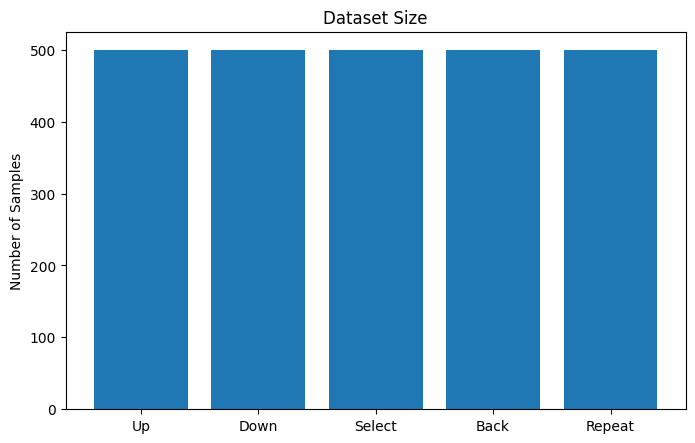

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(count_labels, counts);
plt.title("Dataset Size")
plt.ylabel("Number of Samples")
plt.show()

## Sample Lengths

In [11]:
def _to_lens(data, sr=throat_sr):
    return [len(d) / sr * 1000 for d in data]

# Assuming all raw input channels have same length
lens = [
    _to_lens(raw_throat_1),
    _to_lens(label_splits["up"]["raw_throat_1"]),
    _to_lens(label_splits["down"]["raw_throat_1"]),
    _to_lens(label_splits["select"]["raw_throat_1"]),
    _to_lens(label_splits["back"]["raw_throat_1"]),
    _to_lens(label_splits["repeat"]["raw_throat_1"]),
]
len_labels = ["All", "Up", "Down", "Select", "Back", "Repeat"]

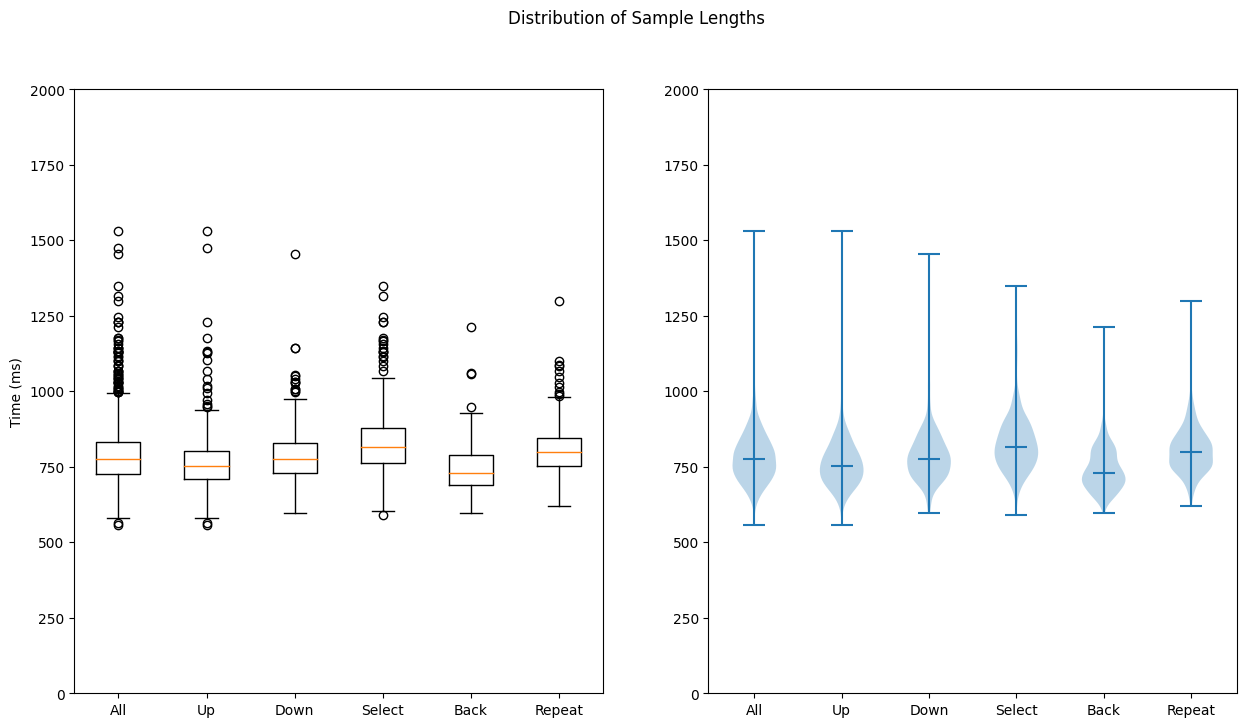

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].boxplot(lens, labels=len_labels)
axs[0].set_ylim(0, 2000)
axs[0].set_ylabel("Time (ms)")

axs[1].violinplot(
    lens,
    showextrema=True,
    showmedians=True
)
axs[1].set_xticks(list(range(1, len(len_labels) + 1)))
axs[1].set_xticklabels(len_labels)
axs[1].set_ylim(0, 2000)

plt.suptitle("Distribution of Sample Lengths")
plt.show()

## Loudness

In [13]:
def _to_loudness(data, sr=throat_sr):
    meter = pln.Meter(sr)
    data = [d.astype(np.float32) for d in data]
    return [meter.integrated_loudness(d) for d in data]

# Assuming all raw input channels have same length
loudnesses = [
    _to_loudness(raw_throat_1),
    _to_loudness(label_splits["up"]["raw_throat_1"]),
    _to_loudness(label_splits["down"]["raw_throat_1"]),
    _to_loudness(label_splits["select"]["raw_throat_1"]),
    _to_loudness(label_splits["back"]["raw_throat_1"]),
    _to_loudness(label_splits["repeat"]["raw_throat_1"]),
]
loudness_labels = ["All", "Up", "Down", "Select", "Back", "Repeat"]

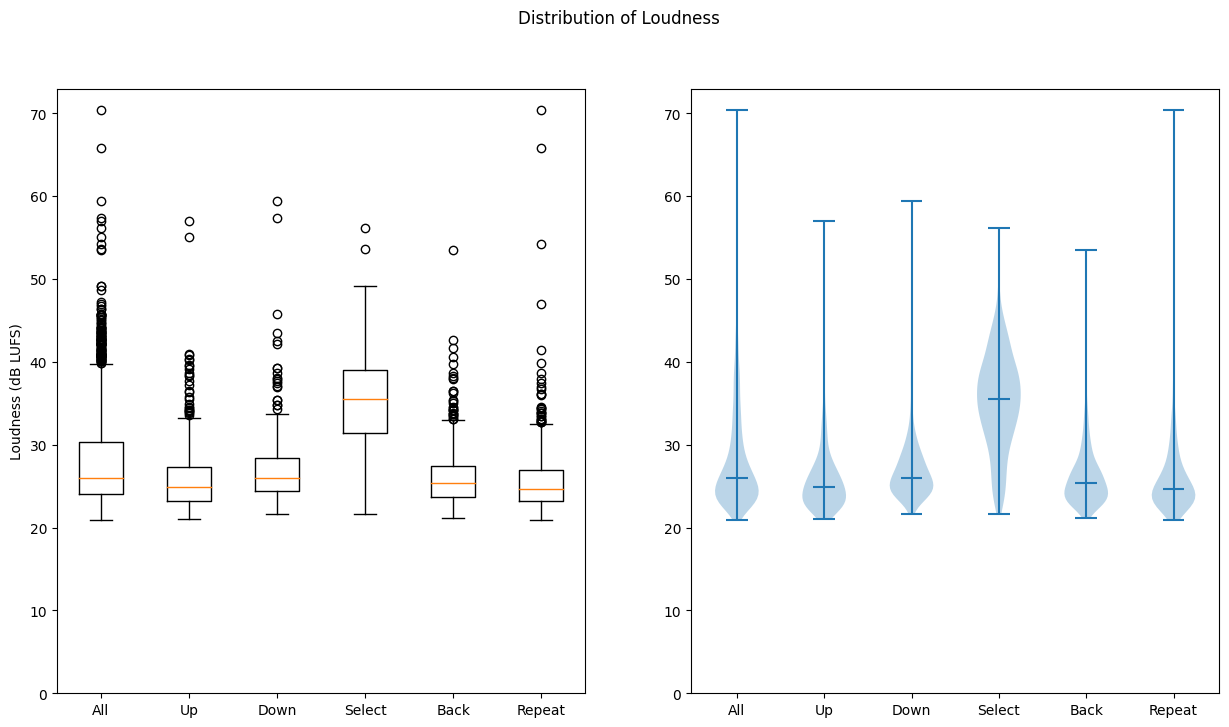

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].boxplot(loudnesses, labels=loudness_labels)
axs[0].set_ylim(0)
axs[0].set_ylabel("Loudness (dB LUFS)")

axs[1].violinplot(
    loudnesses,
    showextrema=True,
    showmedians=True
)
axs[1].set_xticks(list(range(1, len(loudness_labels) + 1)))
axs[1].set_xticklabels(loudness_labels)
axs[1].set_ylim(0)

plt.suptitle("Distribution of Loudness")
plt.show()

# Visualizing Samples

In [15]:
def visualize_single_audio(sr, raw=None, spec=None, ax_wav=None, ax_spec=None, title=None):
    if ax_wav is None and ax_spec is None:
        fig, axs = plt.subplots(2, sharex=True)
        ax_wav = axs[0]
        ax_spec = axs[1]
    
    if raw is not None:
        img = librosa.display.waveplot(raw.astype(np.float32), sr=sr, ax=ax_wav)    
        ax_wav.set_ylim(-800, 800)
        ax_wav.set_xlim(0, 2)
        ax_wav.set_title(title, fontsize=24)
    if spec is not None:
        img = librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='mel', hop_length=config.hop_len, ax=ax_spec)
        ax_spec.set_title(title, fontsize=24)

    # fig.colorbar(img, ax=[axs[0], axs[1]], format="%+2.f dB")
    # display(ipd.Audio(raw, rate=sr))

In [16]:
def vis_wav(raws, targets):
    n = len(raws)
    assert len(raws) == len(targets)

    fig, axes = plt.subplots(figsize=(30, n * 2) , nrows=n // 4, ncols=4, sharey=True, sharex=True) 
    for i in range(n):
        raw = raws[i]
        target = targets[i]
        ax = axes[i // 4][i % 4]
        visualize_single_audio(throat_sr, raw=raw, ax_wav=ax, title=target)
        
def vis_spec(specs, targets):
    n = len(specs)
    assert len(specs) == len(targets)

    fig, axes = plt.subplots(figsize=(30, n * 2) , nrows=n // 4, ncols=4, sharey=True, sharex=True) 
    for i in range(n):
        spec = specs[i]
        target = targets[i]
        ax = axes[i // 4][i % 4]
        visualize_single_audio(throat_sr, spec=spec, ax_spec=ax, title=target)

def vis_side_by_side(raws, specs, targets):
    n = len(raws)
    assert len(raws) == len(specs)
    assert len(raws) == len(targets)
    assert n % 2 == 0
    
    # Nicer target titles
    fig, big_axes = plt.subplots(figsize=(30, n * 2) , nrows=n // 2, ncols=2, sharey=True, sharex=True) 
    for row, axs in enumerate(big_axes):
        for col, big_ax in enumerate(axs):
            big_ax.set_title(f"{targets[row * 2 + col]}", fontsize=24)
            big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
            big_ax._frameon = False

    for i in range(n):
        raw = raws[i]
        spec = specs[i]
        ax_wav = fig.add_subplot(n // 2, 4, i * 2 + 1)
        ax_spec = fig.add_subplot(n // 2, 4, i * 2 + 2)
        visualize_single_audio(throat_sr, raw, spec, ax_wav=ax_wav, ax_spec=ax_spec)

In [17]:
n = 12
sample_idxs = random.sample(list(range(len(dataset))), n)
sample_raw = [raw_throat_1[i] for i in sample_idxs]
sample_proc = [proc_throat_1[i] for i in sample_idxs]
sample_targets = [raw_targets[i] for i in sample_idxs]
sample_idxs

[42, 1818, 1585, 672, 231, 1158, 1577, 1666, 1691, 1740, 856, 1472]

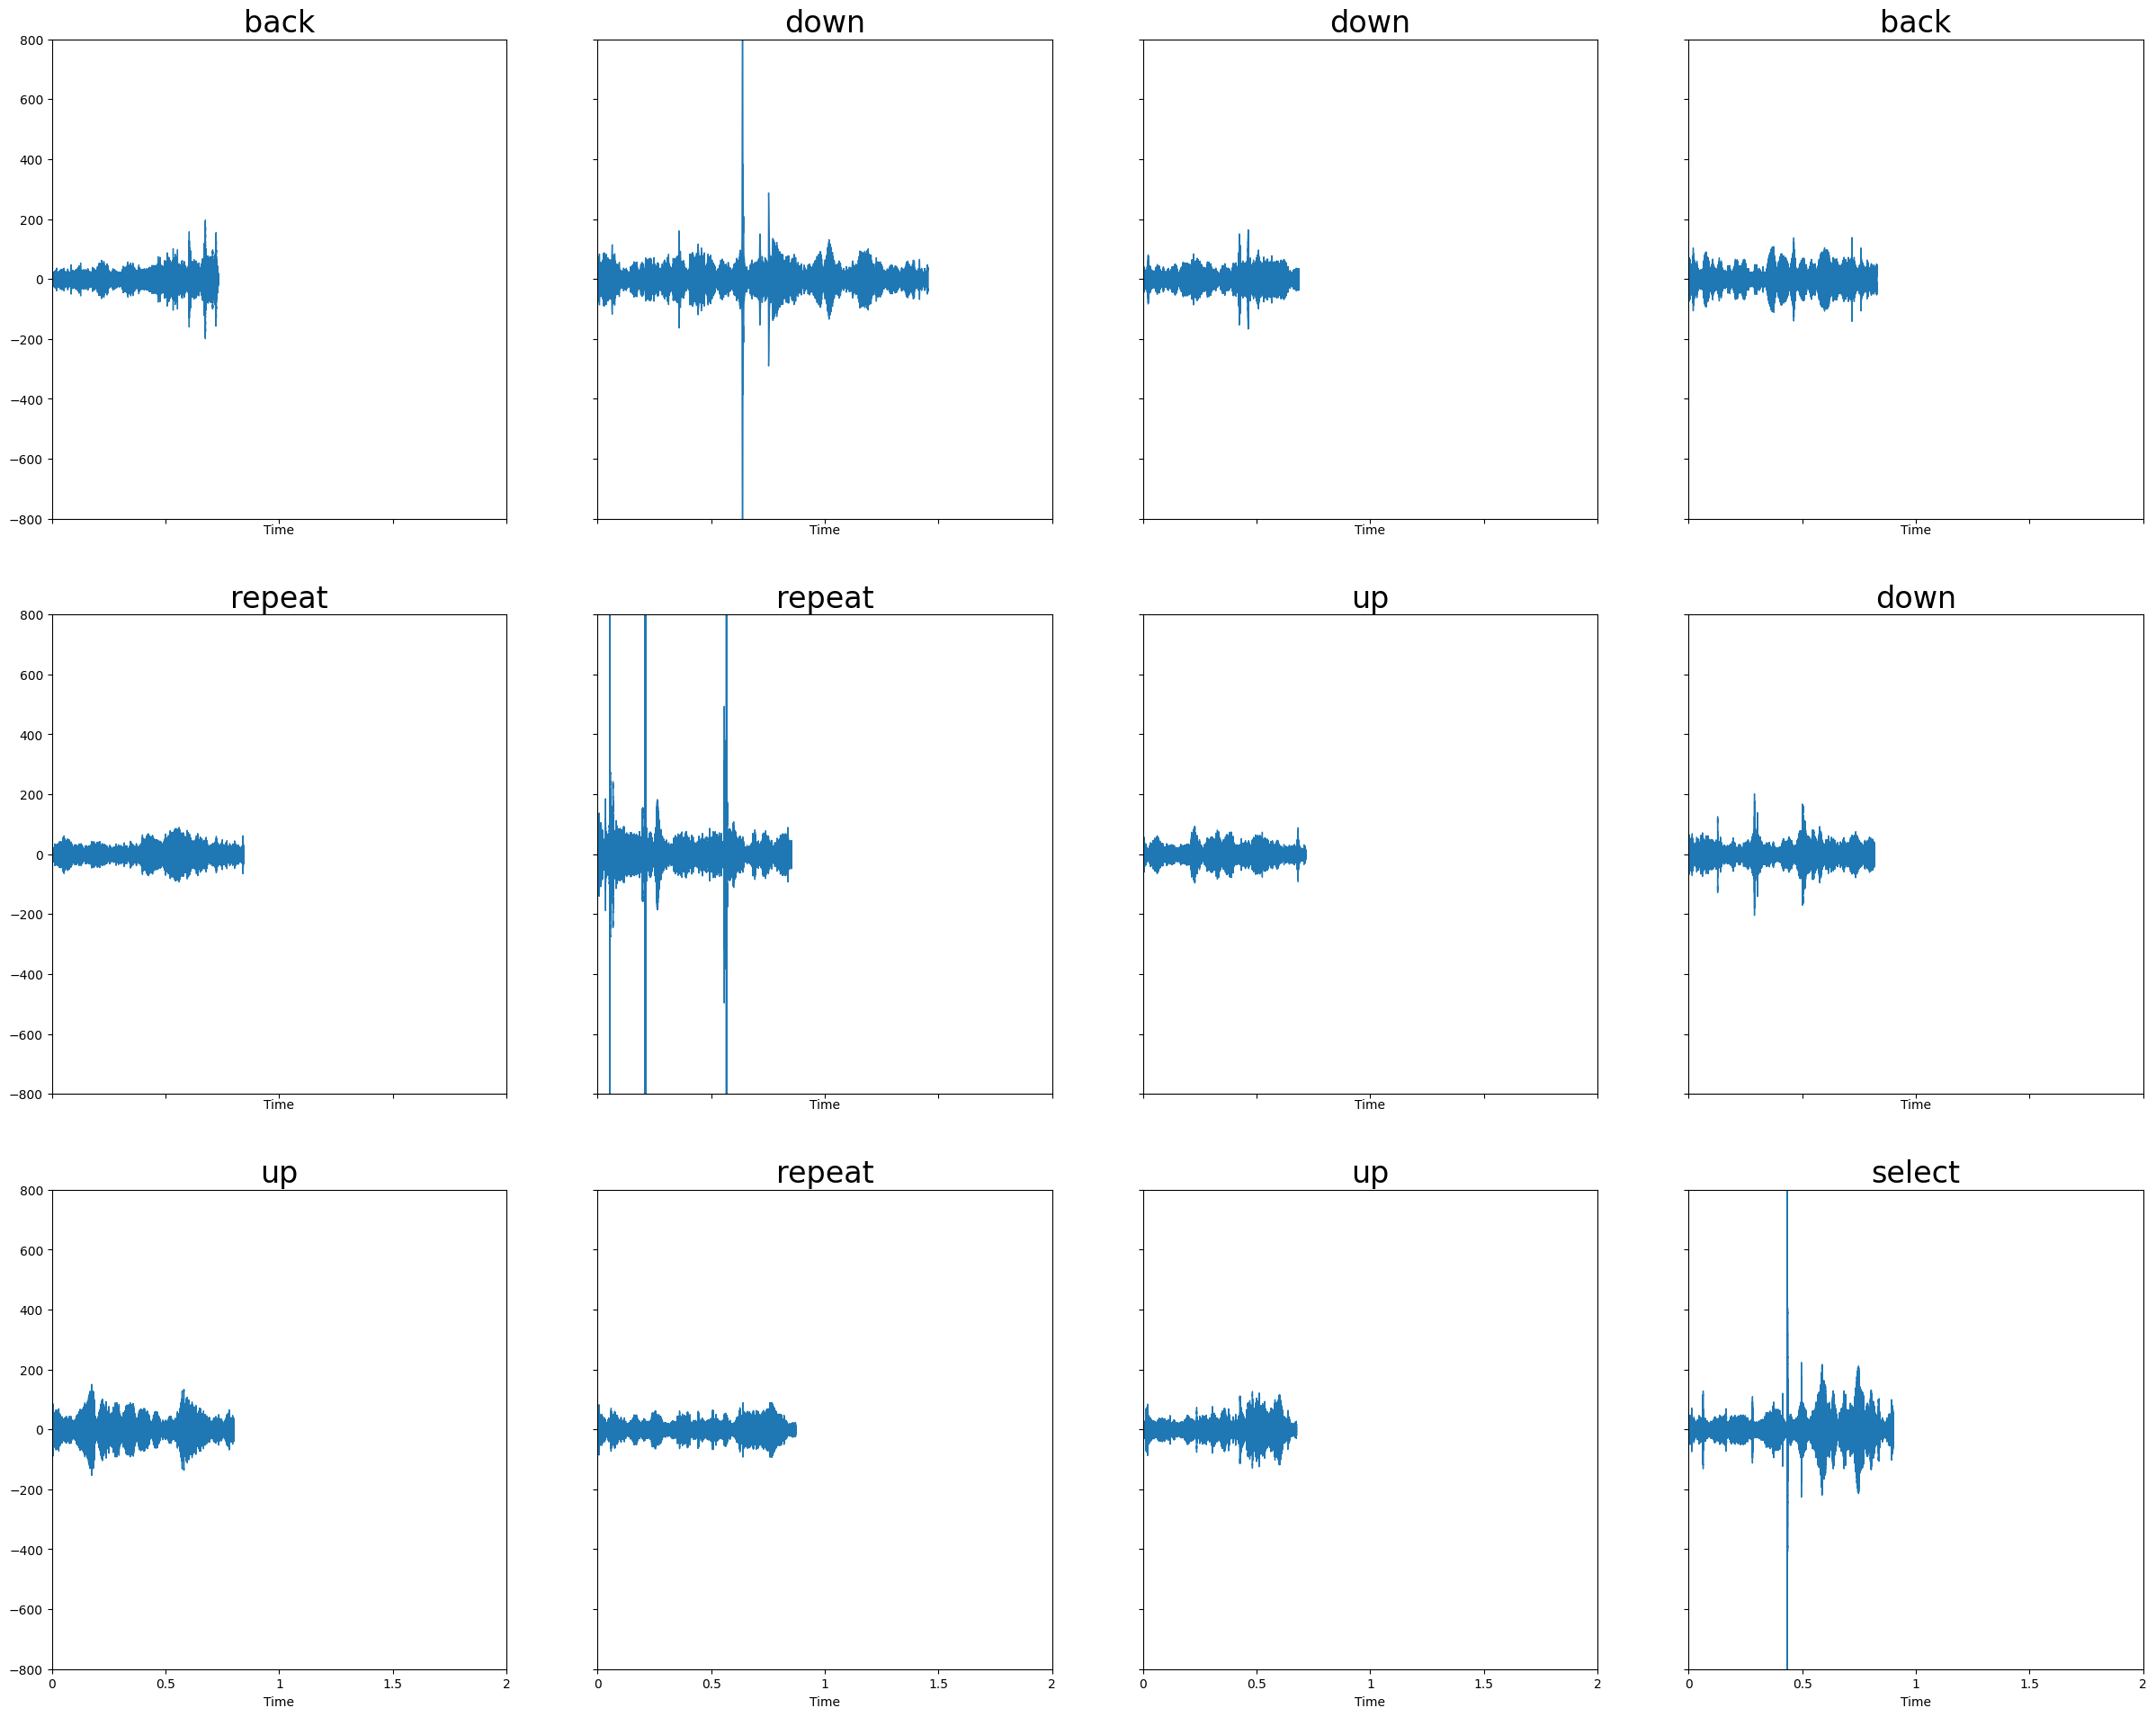

In [18]:
vis_wav(
    sample_raw,
    sample_targets
)

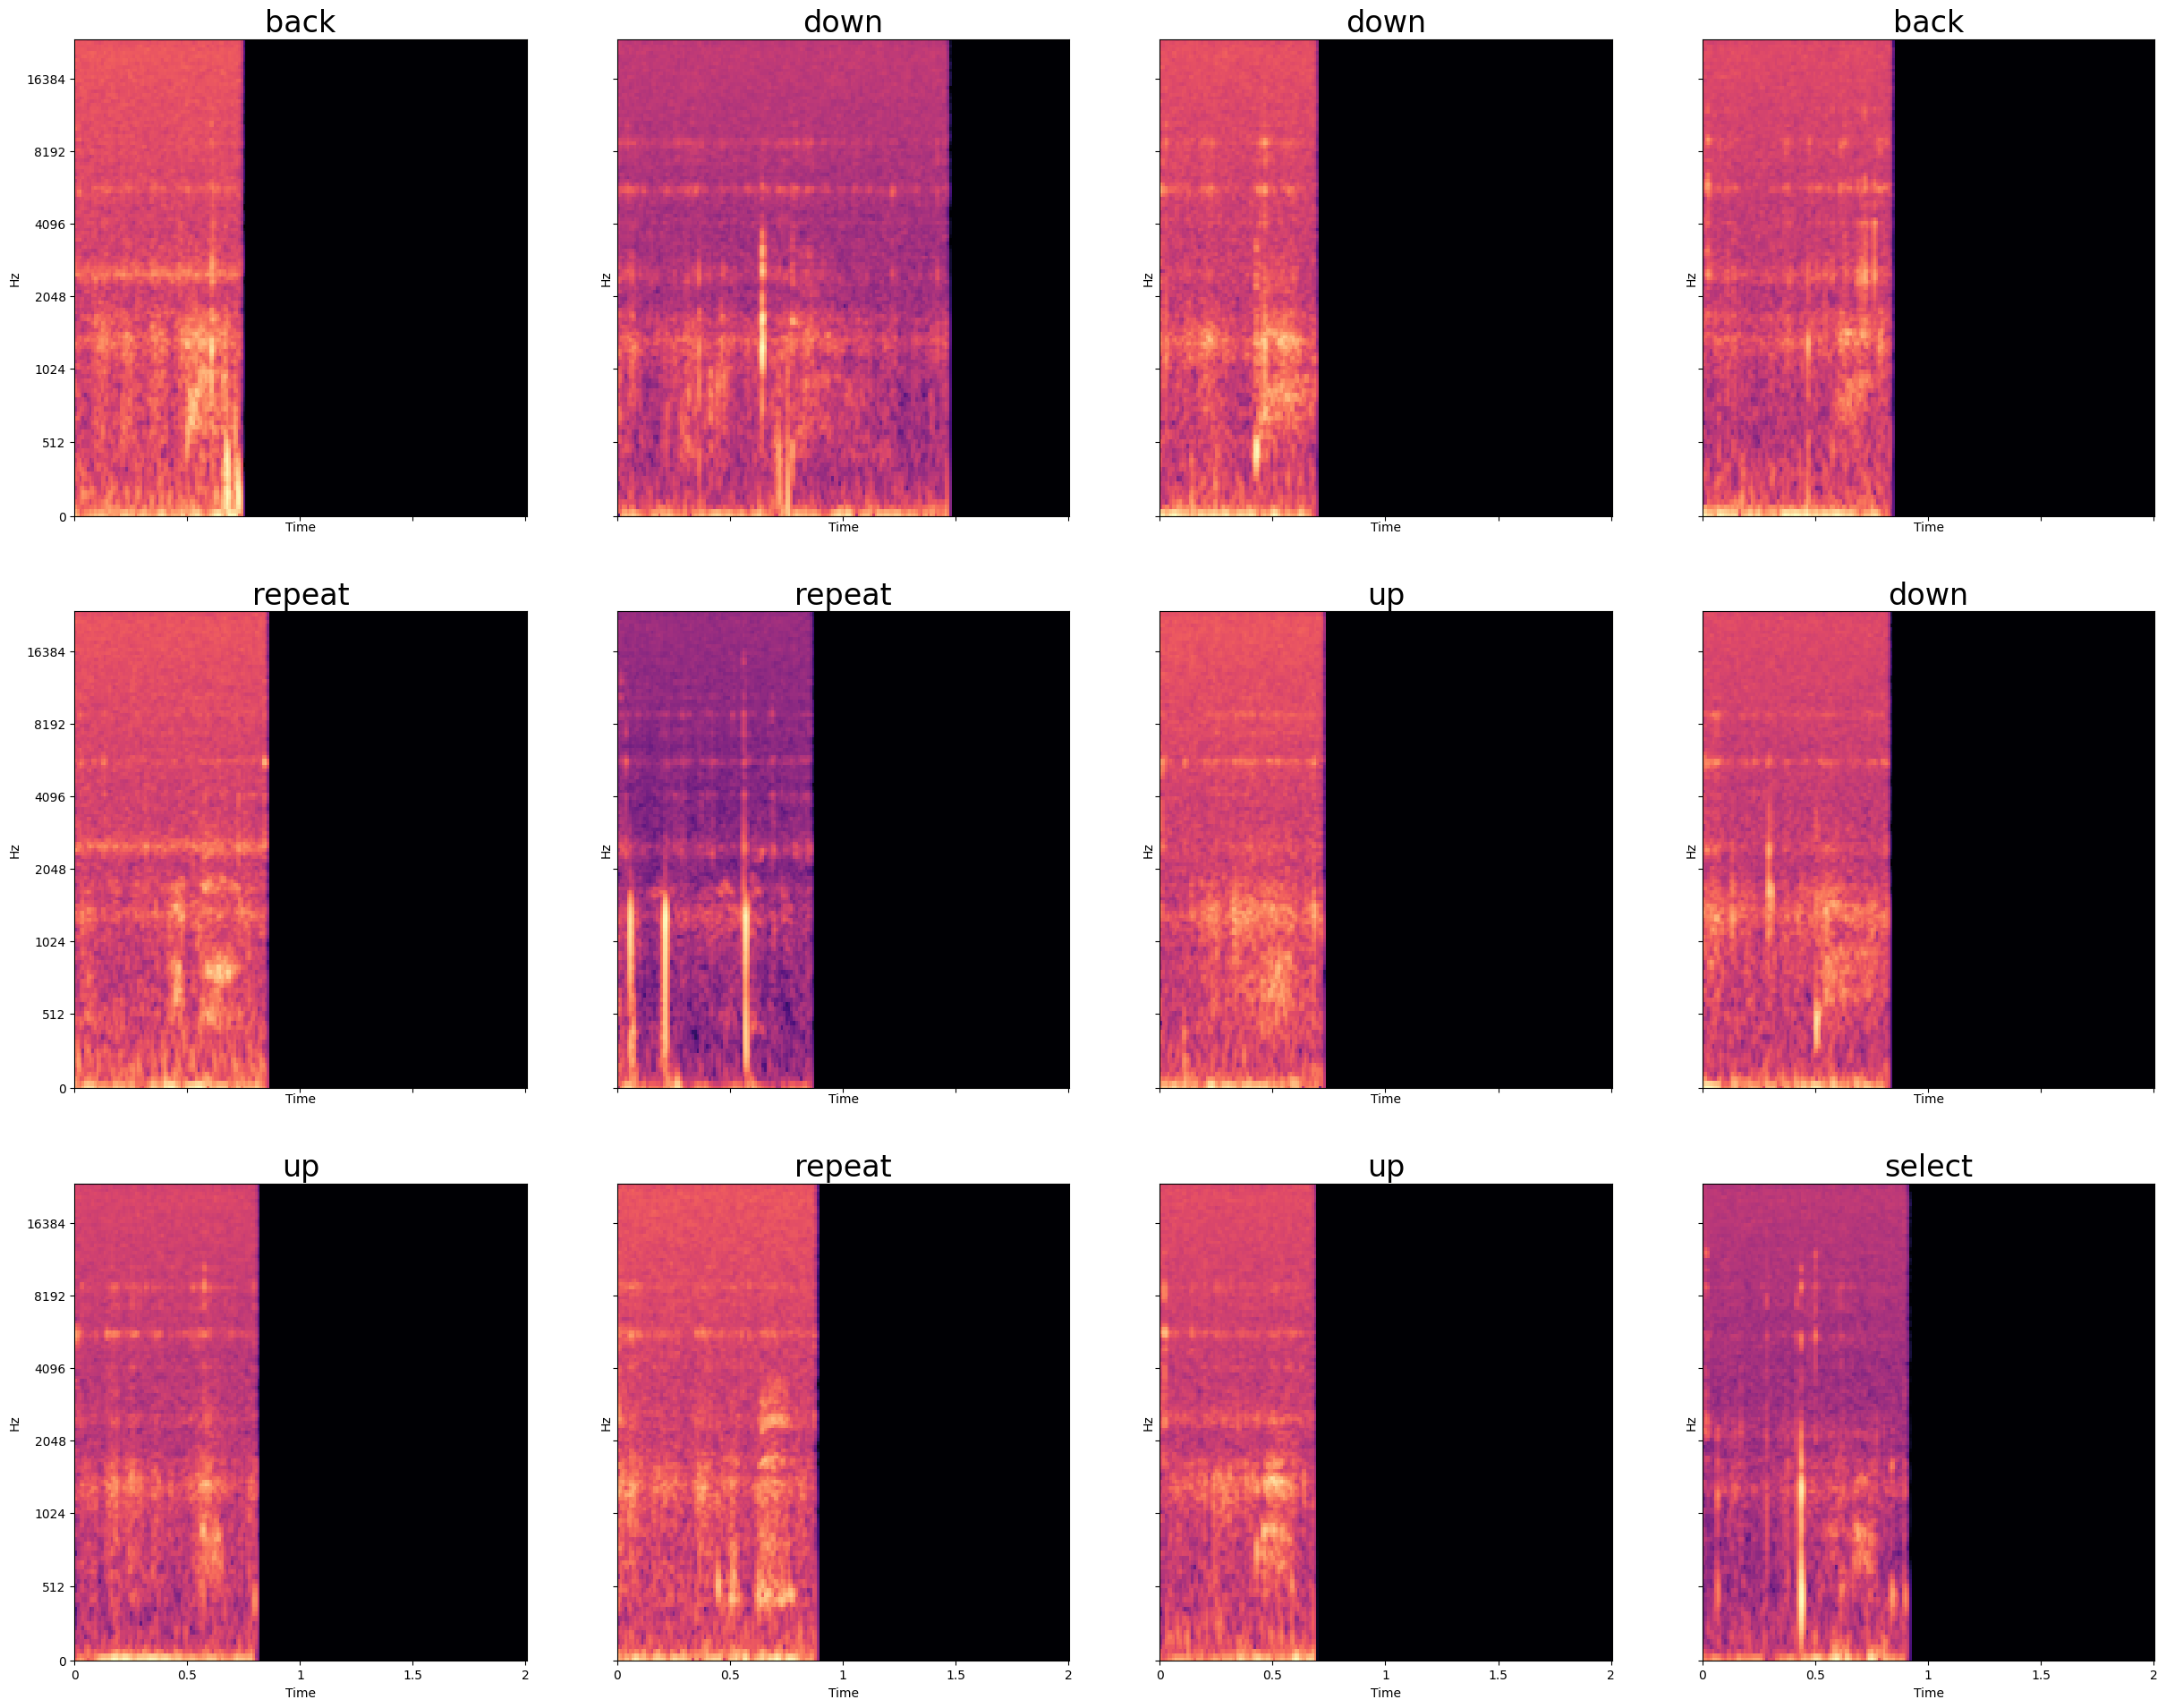

In [19]:
vis_spec(
    sample_proc,
    sample_targets
)

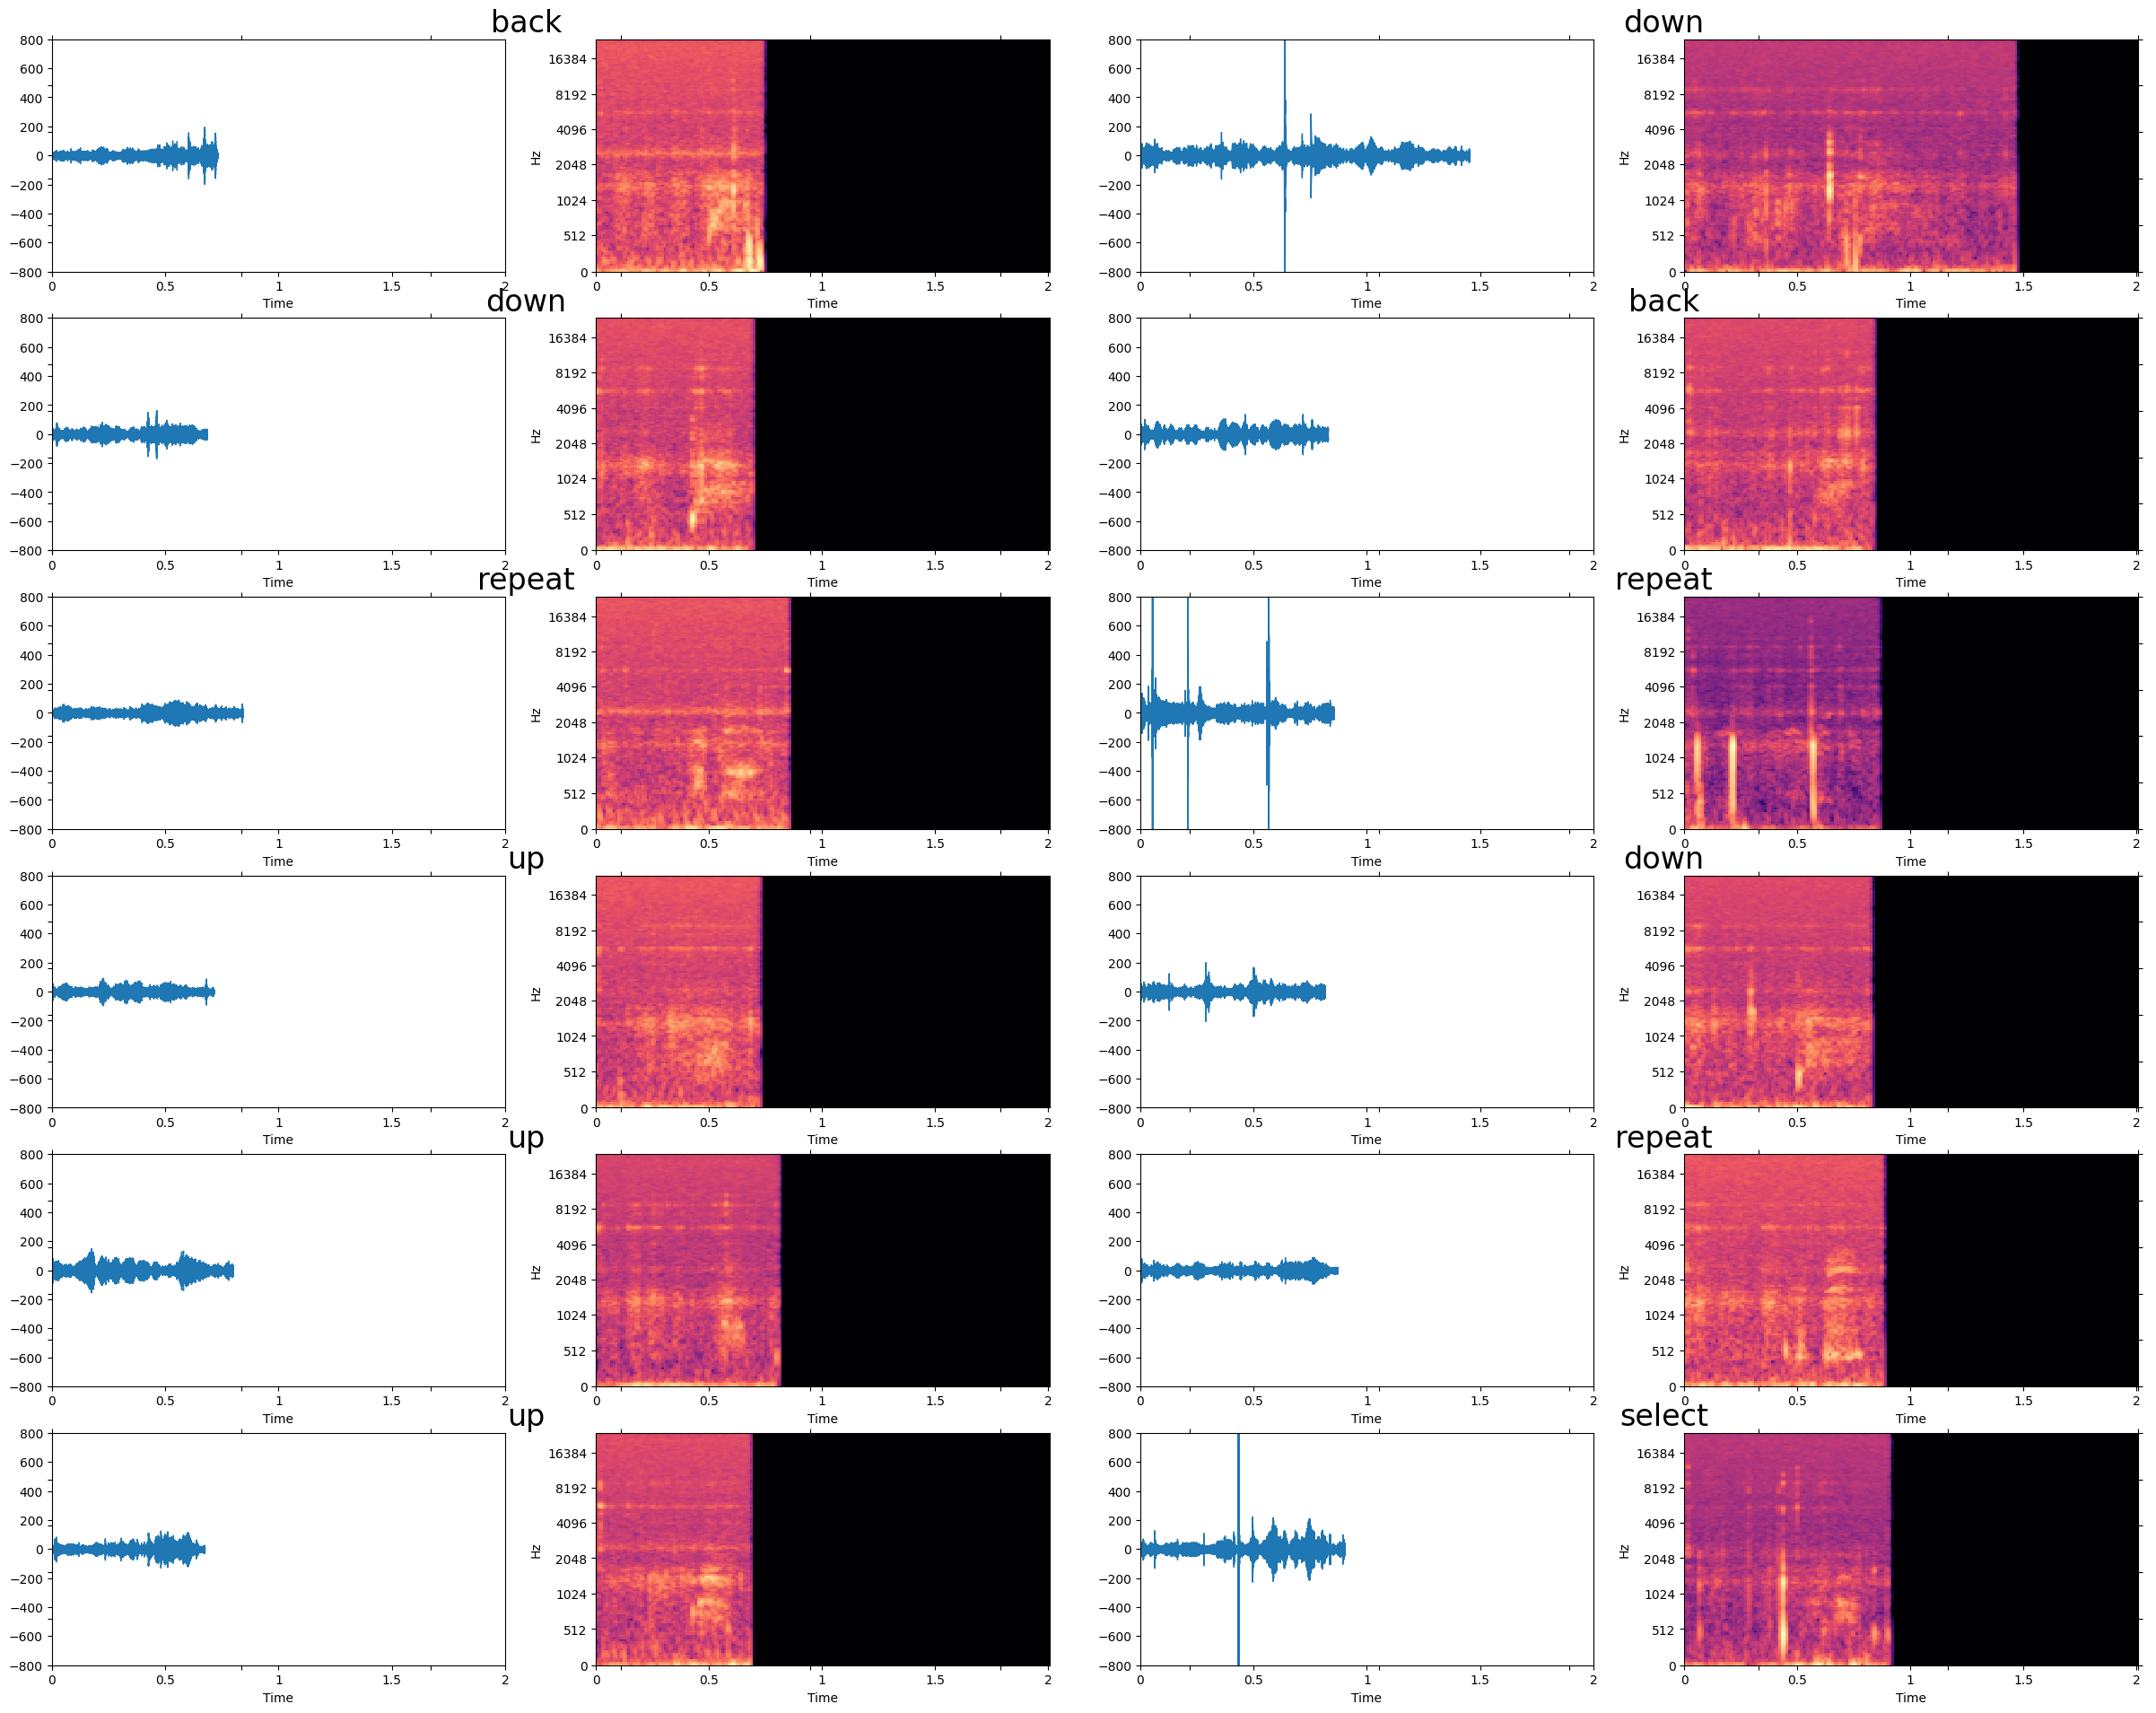

In [20]:
vis_side_by_side(
    sample_raw,
    sample_proc,
    sample_targets,
)